# Hotspot - Coldspot analysis using Moran's I and LISA 

This notebook will analyse the spatial patterns in the pickups/dropoff, trip duration values in Manhattan. I am using Moran's I to understand whether the number of taxi pickups/dropoffs, trip durations are spatially autocorrelated. The general guess is that overall the values will be spatially autocorrelated. But the local values of spatial autocorrelation would help in finding statistically significant areas which have clusters of high values and low values. Such Hotspot-cold spots analysis can be used to leverage statistical significant geographical locations to sell thier products. I have used advertisement as an example.

The cold spots will give an idea of areas which have statistically low values. We can also find spatial outliers in the data 

In [277]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import seaborn as sns
import scipy.stats as sc
import datetime as dt
import shapely as sh
import geopandas as gp
import pysal as ps
from pysal.esda.getisord import G_Local
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist, pdist


# plt.rcParams['figure.figsize'] = [16, 10]
%matplotlib inline

## Import the training pickup and dropoff cleaned data and the nyc census tract shapefile

In [112]:
def remove_central_park(data,ct):

    data.to_file("./Cleaned_data/" + ct + ".shp")
    filepath ="./Cleaned_data/" + ct + ".shp"

    W = ps.queen_from_shapefile(filepath, idVariable='BoroCT2010')

    cp_neigh = W.neighbors[1014300]

    val1 = int(data[data.BoroCT2010 == 1014300].id / len(cp_neigh))

    data.set_index('BoroCT2010', inplace=True)

    for cp_n in cp_neigh:
        data.loc[cp_n, 'id'] = data.loc[cp_n, 'id'] + val1
    

    data.reset_index(inplace=True)

    ## Remove central park from the dataset
    data.drop(data[data.BoroCT2010 == 1014300].index, axis=0, inplace=True)

    return data

In [139]:
nyct = gp.read_file("./nyct2010_17c/nyct2010.shp")
nyct.to_crs(epsg=4326, inplace=True)
nyct = nyct[['BoroCT2010', 'BoroName', 'geometry']]
nyct.BoroCT2010 = nyct.BoroCT2010.astype('int')
nyct = nyct[nyct.BoroName == 'Manhattan']

In [140]:
pickups = pd.read_csv("./Cleaned_data/tp_full.csv")
pickups.drop(['Unnamed: 0'], axis=1, inplace=True)

dropoffs = pd.read_csv("./Cleaned_data/td_full.csv")
dropoffs.drop(['Unnamed: 0'], axis=1, inplace=True)

## Convert pickups and dropoffs to shapefile by merging with census tract shapefile 

In [141]:
pickups = pickups.groupby('BoroCT2010').agg({'id':'count'})
dropoffs = dropoffs.groupby('BoroCT2010').agg({'id':'count'})

pickups.reset_index(inplace=True)
dropoffs.reset_index(inplace=True)

pickups = pd.merge(pickups, nyct, on='BoroCT2010', how='inner')
dropoffs = pd.merge(dropoffs, nyct, on='BoroCT2010', how='inner')

crs = {'init': 'epsg:4326', 'no_defs': True}
pickups = gp.GeoDataFrame(pickups, crs=crs, geometry=pickups.geometry)
dropoffs = gp.GeoDataFrame(dropoffs, crs=crs, geometry=dropoffs.geometry)

In [142]:
pickups = remove_central_park(pickups, 'BoroCT2010')
dropoffs = remove_central_park(dropoffs, 'BoroCT2010')

## For our analysis we will consider areas with pickups greater than at least 50

In [143]:
pickups = pickups[pickups.id > 50]
pickups.reset_index(inplace=True, drop=True)

In [144]:
ps.Natural_Breaks(pickups.id, k=10)

                Natural_Breaks                
 
  Lower              Upper               Count
            x[i] <=   798.000               68
  798.000 < x[i] <=  2180.000               30
 2180.000 < x[i] <=  4624.000               20
 4624.000 < x[i] <=  7025.000               26
 7025.000 < x[i] <= 10094.000               28
10094.000 < x[i] <= 13092.000               40
13092.000 < x[i] <= 17326.000               27
17326.000 < x[i] <= 24185.000               18
24185.000 < x[i] <= 32707.000                3
32707.000 < x[i] <= 55763.000                1

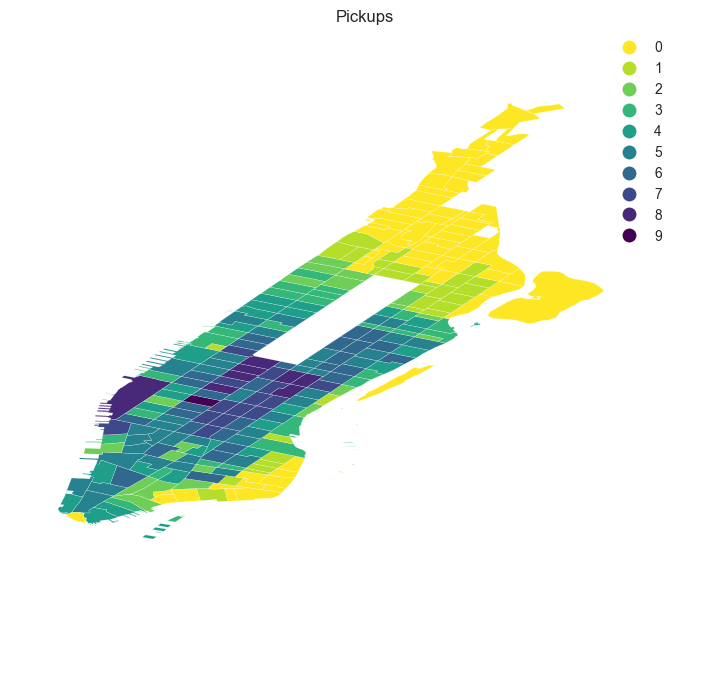

In [147]:
tp10 = ps.Natural_Breaks(pickups.id, k=10)
f, ax = plt.subplots(1, figsize=(8,8))
pickups.assign(cl=tp10.yb).plot(column='cl', categorical=True,
                                k=10, cmap='viridis_r', linewidth=0.1, ax=ax, alpha = 1,
                                edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Pickups")
plt.show()

The maps shows that most pickups are concentrated within midtown manhattan. Next task is to check whether there is spatial relationship between observed values

In [152]:
pickups.to_file("./Cleaned_data/pickups_tmp.shp")
filepath ="./Cleaned_data/pickups_tmp.shp"

W = ps.queen_from_shapefile(filepath, idVariable='BoroCT2010')
W.transform = 'r'

('WARNING: ', 1023801, ' is an island (no neighbors)')


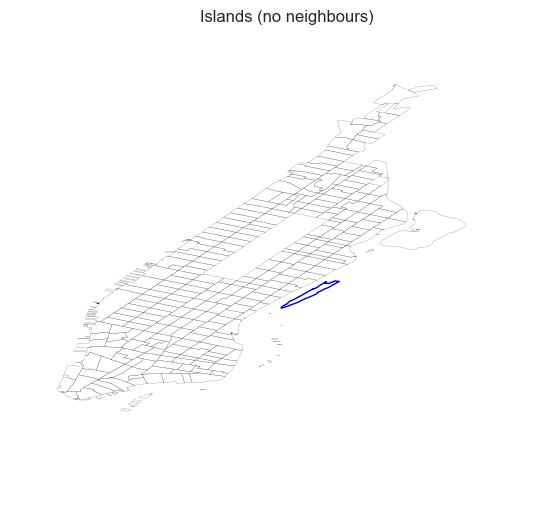

In [153]:
f, ax = plt.subplots(1, figsize=(6,6))
pickups[pickups.BoroCT2010.isin(W.islands)].plot(ax=ax, edgecolor = 'b', alpha = 1)
pickups.plot(ax=ax, edgecolor = 'black', color='white', alpha = 1, linewidth=0.1)
ax.set_axis_off()
plt.title("Islands (no neighbours)")
plt.show()

In [154]:
pickupsLag = ps.lag_spatial(W, pickups.id)

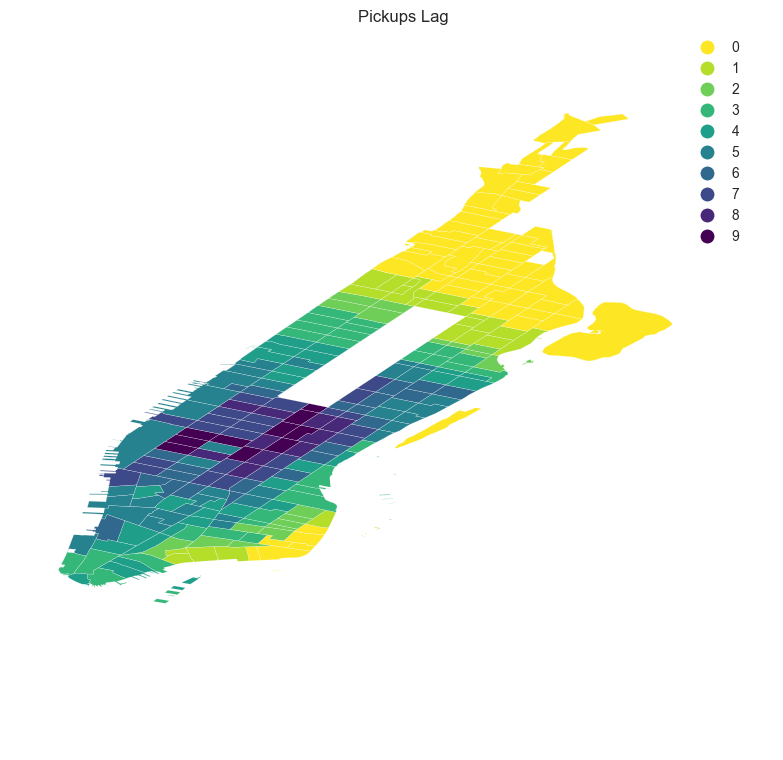

In [156]:
pickupsLag10 = ps.Natural_Breaks(pickupsLag, k=10)
f, ax = plt.subplots(1, figsize=(9, 9))
pickups.assign(cl=pickupsLag10.yb).plot(column='cl', categorical=True,
                                k=10, cmap='viridis_r', linewidth=0.1, ax=ax, alpha= 1,
                                edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Pickups Lag")
plt.show()

This is the map of spatial lag of pickups, each census tract is given value of the mean value of pickups of its surrounding neighbours. We can see that most of the high values are in midtown. 

In [157]:
tp = pickups.id
b,a = np.polyfit(tp, pickupsLag, 1)

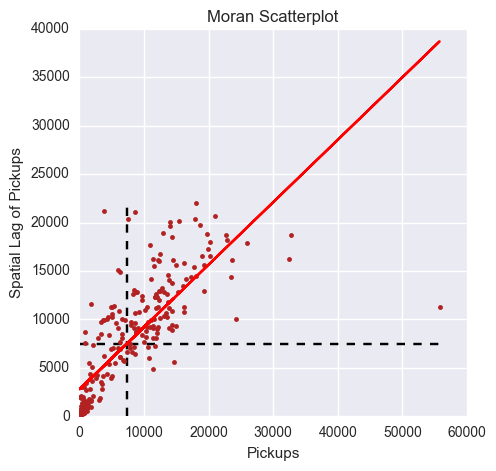

In [159]:
f, ax = plt.subplots(1, figsize=(5, 5))

plt.plot(tp, pickupsLag, '.', color='firebrick')

 # dashed vert at mean of pickups
plt.vlines(tp.mean(), pickupsLag.min(), pickupsLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged pickups
plt.hlines(pickupsLag.mean(), tp.min(), tp.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(tp, a + b*tp, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Pickups')
plt.xlabel('Pickups')
plt.show()

The scatterplot is the value of pickups in Census tract wrt to its spatial lag(mean of values of neighbours). The four quadrants are created from the mean values(dashed lines)

## Calculate Global Moran's I and check if its statistically significant

In [168]:
I_pickups = ps.Moran(pickups.id.values, W, permutations=9999)

In [169]:
I_pickups.I, I_pickups.p_sim

(0.64315876519018367, 0.0001)

The p_values is 0.0001 and the value of Moran's I is statistically significant. This means there is spatial autocorrelation overall in Manhattan

### Local Indicators of Spatial Association (LISA)

In [171]:
LMo_tp = ps.Moran_Local(pickups.id.values, W, permutations=99999)

In [172]:
sigs = tp[LMo_tp.p_sim <= .001]
W_sigs = pickupsLag[LMo_tp.p_sim <= .001]
insigs = tp[LMo_tp.p_sim > .001]
W_insigs = pickupsLag[LMo_tp.p_sim > .001]

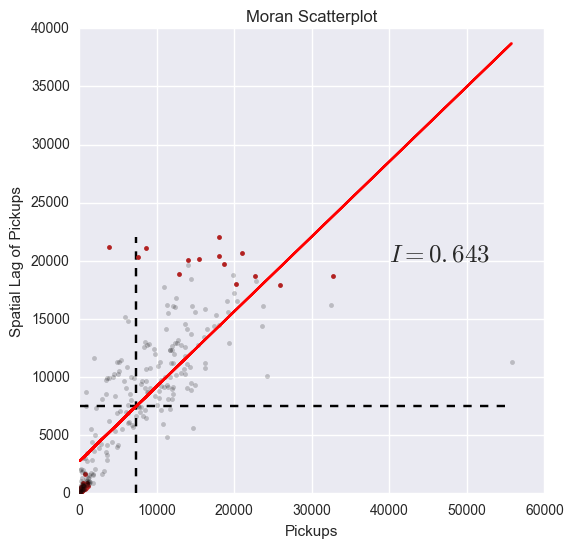

In [173]:
plt.figure(figsize=(6,6))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
 # dashed vert at mean of pickups
plt.vlines(tp.mean(), pickupsLag.min(), pickupsLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged pickups
plt.hlines(pickupsLag.mean(), tp.min(), tp.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(tp, a + b*tp, 'r')
plt.text(s='$I = %.3f$' % I_pickups.I, x=40010, y=20010, fontsize=18)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Pickups')
plt.xlabel('Pickups')
plt.show()

This scatter plot has dark red points that are areas which have statistically significant local Moran's I

* High - High : 1
* Low  - High : 2
* Low  - Low  : 3
* High - Low  : 4

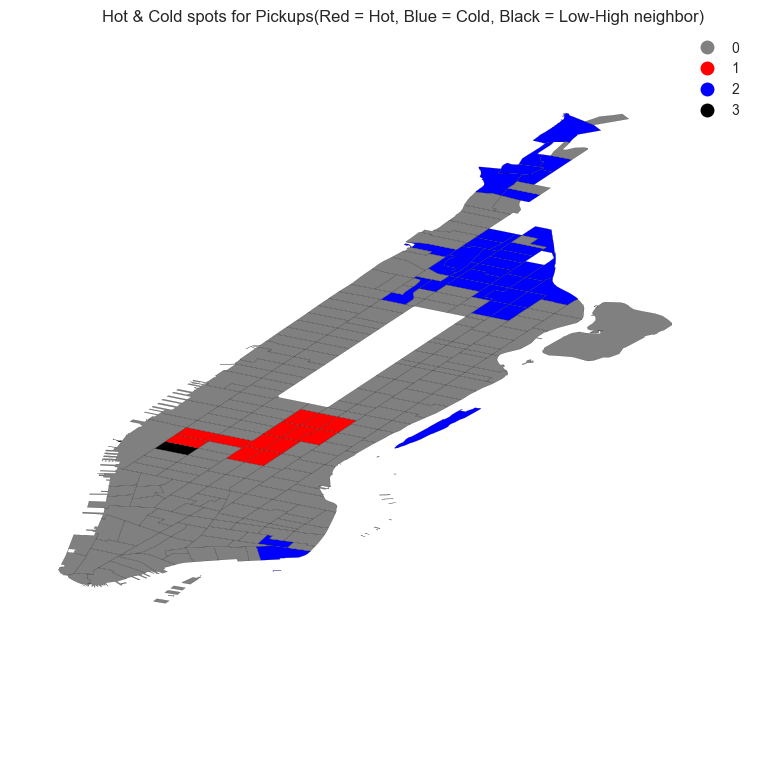

In [287]:
sig = LMo_tp.p_sim <= .001

hotspots = LMo_tp.q == 1 * sig

coldspots = LMo_tp.q==3 * sig

LH = LMo_tp.q==2 * sig

hcmap = colors.ListedColormap(['grey', 'red','blue', 'black'])
hotcold = hotspots*1 + coldspots*2 + LH*3
f, ax = plt.subplots(1, figsize=(9, 9))
pickups.assign(cl=hotcold).plot(column='cl', categorical=True, alpha = 1,\
        k=2, cmap=hcmap,linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.title("Hot & Cold spots for Pickups(Red = Hot, Blue = Cold, Black = Low-High neighbor)")
plt.show()

The above map shows the hot and cold spots for pickups calculated using LISA. The black census tract is an outlier with extremely high pickups. That census tract is near Penn station 

In [175]:
dropoffs = dropoffs[dropoffs.id > 50]
dropoffs.reset_index(inplace=True, drop=True)
dropoffs.to_file("./Cleaned_data/dropoffs_tmp.shp")
filepath ="./Cleaned_data/dropoffs_tmp.shp"

Wd = ps.queen_from_shapefile(filepath, idVariable='BoroCT2010')
Wd.transform = 'r'

('WARNING: ', 1030900, ' is an island (no neighbors)')


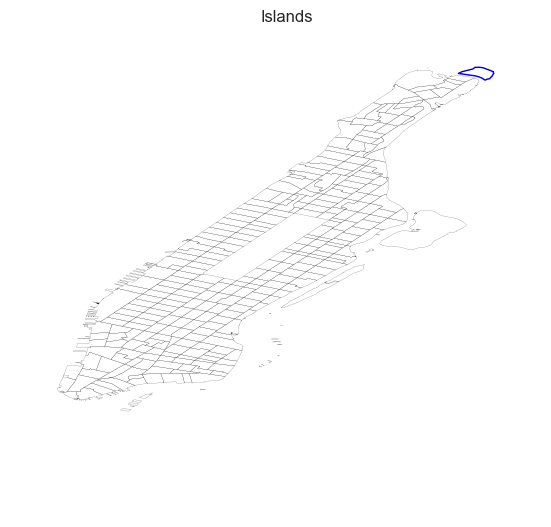

In [176]:
f, ax = plt.subplots(1, figsize=(6,6))
dropoffs[dropoffs.BoroCT2010.isin(Wd.islands)].plot(ax=ax, edgecolor = 'b', alpha = 1)
dropoffs.plot(ax=ax, edgecolor = 'black', color='white', alpha = 1, linewidth=0.1)
ax.set_axis_off()
plt.title("Islands")
plt.show()

In [243]:
dropoffsLag = ps.lag_spatial(Wd, dropoffs.id)

td = dropoffs.id
bd,ad = np.polyfit(td, dropoffsLag, 1)

I_dropoffs = ps.Moran(dropoffs.id.values, Wd, permutations=99999)
I_dropoffs.I, I_dropoffs.p_sim

(0.68002488153334839, 1.0000000000000001e-05)

In [244]:
LMo_td = ps.Moran_Local(dropoffs.id.values, Wd, permutations=99999)

sigsd = td[LMo_td.p_sim <= .001]
W_sigsd = dropoffsLag[LMo_td.p_sim <= .001]
insigsd = td[LMo_td.p_sim > .001]
W_insigsd = dropoffsLag[LMo_td.p_sim > .001]

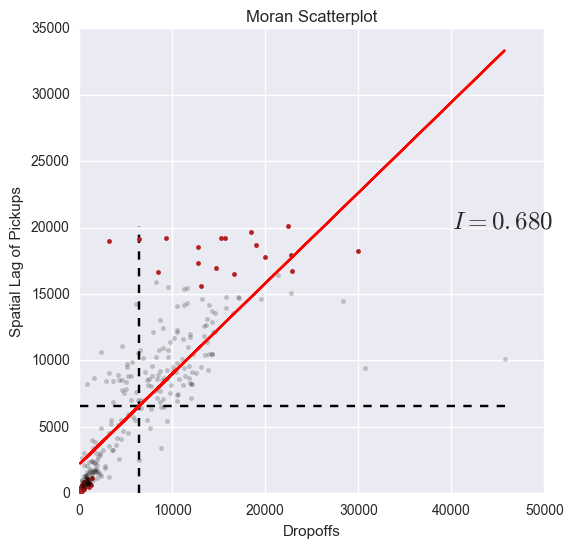

In [245]:
plt.figure(figsize=(6,6))
plt.plot(sigsd, W_sigsd, '.', color='firebrick')
plt.plot(insigsd, W_insigsd, '.k', alpha=.2)
 # dashed vert at mean of pickups
plt.vlines(td.mean(), dropoffsLag.min(), dropoffsLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged pickups
plt.hlines(dropoffsLag.mean(), td.min(), td.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(td, ad + bd*td, 'r')
plt.text(s='$I = %.3f$' % I_dropoffs.I, x=40010, y=20010, fontsize=18)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Pickups')
plt.xlabel('Dropoffs')
plt.show()

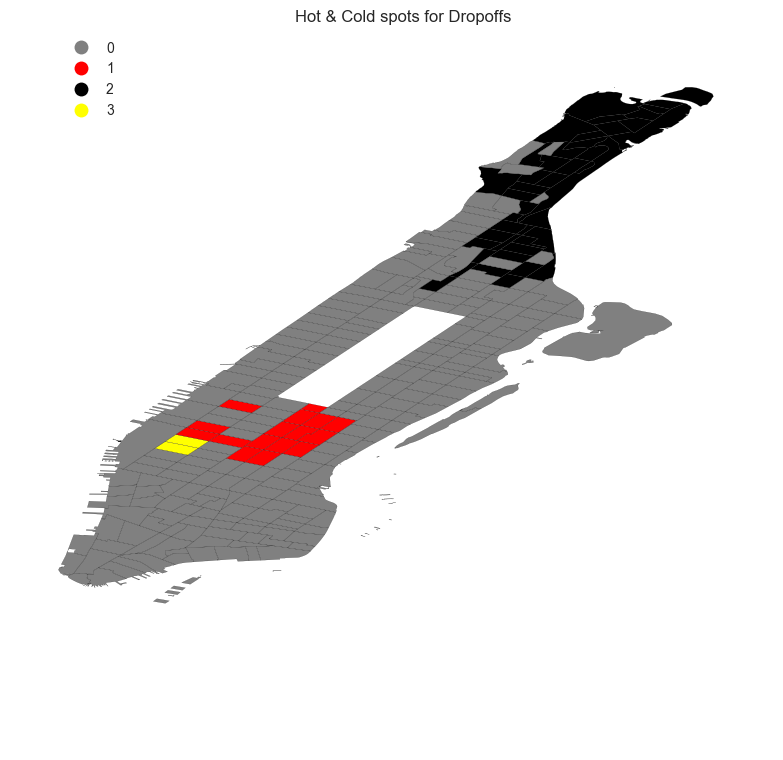

In [249]:
sigd = LMo_td.p_sim <= .001

hotspotsd = LMo_td.q == 1 * sigd

coldspotsd = LMo_td.q==3 * sigd

LHd = LMo_td.q==2 * sigd

HLd = LMo_td.q==4 * sigd


hcmap = colors.ListedColormap(['grey', 'red', 'blue', 'black', 'yellow'])
hotcoldd = hotspotsd* + coldspotsd*2 + LHd*3 + HLd*4
f, ax = plt.subplots(1, figsize=(9, 9))
dropoffs.assign(cl=hotcoldd).plot(column='cl', categorical=True, alpha = 1,\
        k=4, cmap=hcmap, linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.title("Hot & Cold spots for Dropoffs (1=hot, 2=cold, 3=Low-High neighbors, 4=High-Lowneighbours)")
plt.show()

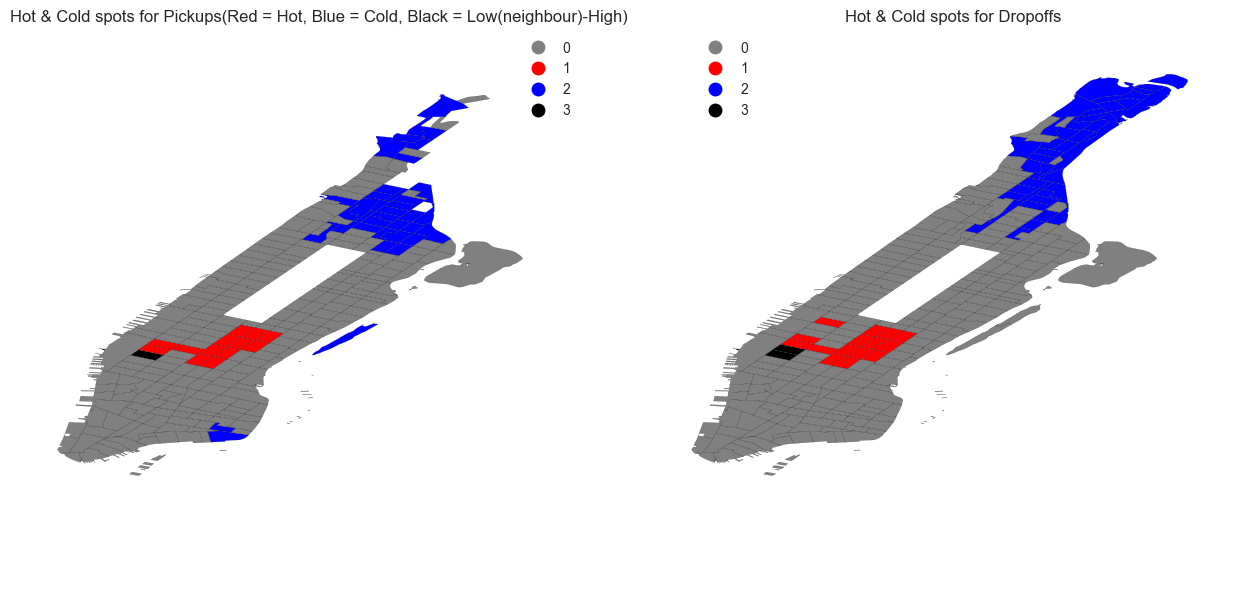

In [185]:
plt.figure(figsize=(15,7))
sig = LMo_tp.p_sim <= .001

hotspots = LMo_tp.q == 1 * sig

coldspots = LMo_tp.q==3 * sig

LH = LMo_tp.q==2 * sig

hcmap = colors.ListedColormap(['grey', 'red','blue', 'black'])
hotcold = hotspots*1 + coldspots*2 + LH*3
ax1 = plt.subplot(1,2,1)
pickups.assign(cl=hotcold).plot(column='cl', categorical=True, alpha = 1,\
        k=2, cmap=hcmap,linewidth=0.1, ax=ax1, \
        edgecolor='black', legend=True)
ax1.set_axis_off()
ax1.set_title("Hot & Cold spots for Pickups(Red = Hot, Blue = Cold, Black = Low(neighbour)-High)")
# plt.show()

sigd = LMo_td.p_sim <= .001

hotspotsd = LMo_td.q == 1 * sigd

coldspotsd = LMo_td.q==3 * sigd

LHd = LMo_td.q==2 * sigd

hcmap = colors.ListedColormap(['grey', 'red','blue', 'black'])
hotcoldd = hotspotsd*1 + coldspotsd*2 + LHd*3
ax2 = plt.subplot(1,2,2)
dropoffs.assign(cl=hotcoldd).plot(column='cl', categorical=True, alpha = 1,\
        k=3, cmap=hcmap,linewidth=0.1,ax = ax2,  \
        edgecolor='black', legend=True)
ax2.set_axis_off()
ax2.set_title("Hot & Cold spots for Dropoffs")
plt.show()

In [284]:
def hotspot_coldspot(data, var, trend):
    
    data = data[data.id > 50]
    data.reset_index(inplace=True, drop=True)
    data.to_file("./Cleaned_data/" + var +".shp")
    filepath ="./Cleaned_data/" + var +".shp"
    
    W = ps.queen_from_shapefile(filepath, idVariable='BoroCT2010')
    W.transform = 'r'

    LagVar = ps.lag_spatial(W, data[var])
    
    VarValues = data[var]
    b,a = np.polyfit(VarValues, LagVar, 1)

    I_data = ps.Moran(data[var].values, W, permutations=99999)
    print "Global Moran's I: ", I_data.I 
    print "p-value: ", I_data.p_sim
    
    LISA_data = ps.Moran_Local(data[var].values, W, permutations=99999)

    sigs = VarValues[LISA_data.p_sim <= .001]
    W_sigs = LagVar[LISA_data.p_sim <= .001]
    insigs = VarValues[LISA_data.p_sim > .001]
    W_insigs = LagVar[LISA_data.p_sim > .001]
    
    plt.figure(figsize=(6,6))
    plt.plot(sigs, W_sigs, '.', color='firebrick')
    plt.plot(insigs, W_insigs, '.k', alpha=.2)
     # dashed vert at mean of pickups
    plt.vlines(VarValues.mean(), LagVar.min(), LagVar.max(), linestyle='--')
     # dashed horizontal at mean of lagged pickups
    plt.hlines(LagVar.mean(), VarValues.min(), VarValues.max(), linestyle='--')

    # red line of best fit using global I as slope
    plt.plot(VarValues, a + b*VarValues, 'r')
    plt.text(s='$I = %.3f$' % I_data.I, x=VarValues.max()+2, y=LagVar.max()-3, fontsize=18)
    plt.title('Moran Scatterplot')
    plt.ylabel('Spatial Lag')
    plt.xlabel('Variable')
    plt.show()
    
    
    
    sig = LISA_data.p_sim <= .001

    hotspots = LISA_data.q == 1 * sig
    coldspots = LISA_data.q==3 * sig
    LH = LISA_data.q==2 * sig
    HL = LISA_data.q==4 * sig
    
    
    hcmap = colors.ListedColormap(['grey', 'red', 'blue', 'black', 'yellow'])
    hotcold = hotspots*1 + coldspots*2 + LH*3 + HL*4
       
    f, ax = plt.subplots(1, figsize=(9, 9))
    data.assign(cl=hotcold).plot(column='cl', categorical=True, alpha = 1,\
        k=4, cmap=hcmap, linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
    ax.set_axis_off()
    plt.suptitle("Hot & Cold spots (1=hot, 2=cold, 3=Low-High neighbors, 4=High-Low neighbours)")
    plt.title(trend)
    plt.show()

Global Moran's I:  0.502324988542
p-value:  1e-05


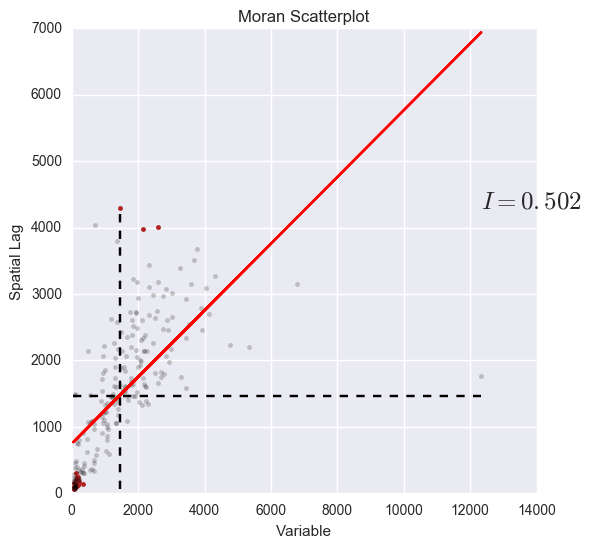

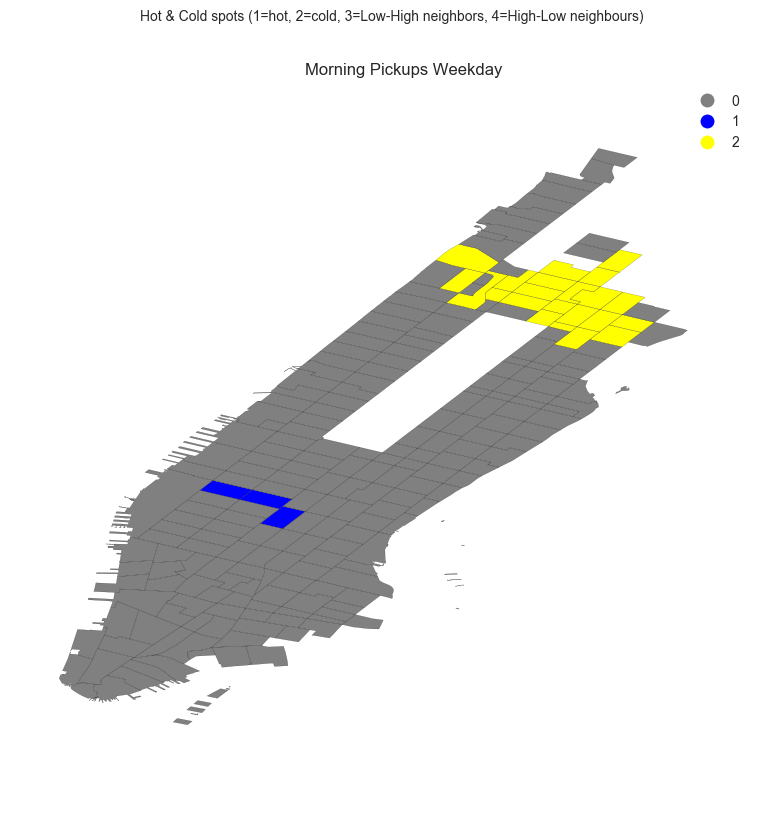

In [288]:
morning_pickups_wd = gp.read_file('./Temporal/morning_pickups_wd.shp')
hotspot_coldspot(morning_pickups_wd, 'id', 'Morning Pickups Weekday')

('WARNING: ', 1022900, ' is an island (no neighbors)')
Global Moran's I:  0.418583130926
p-value:  1e-05


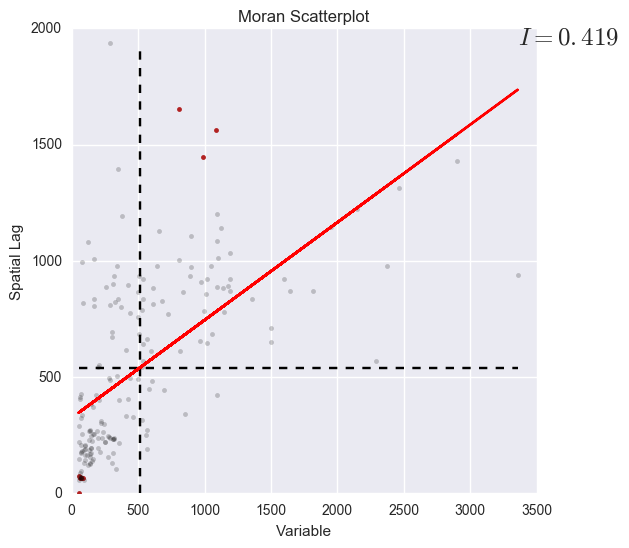

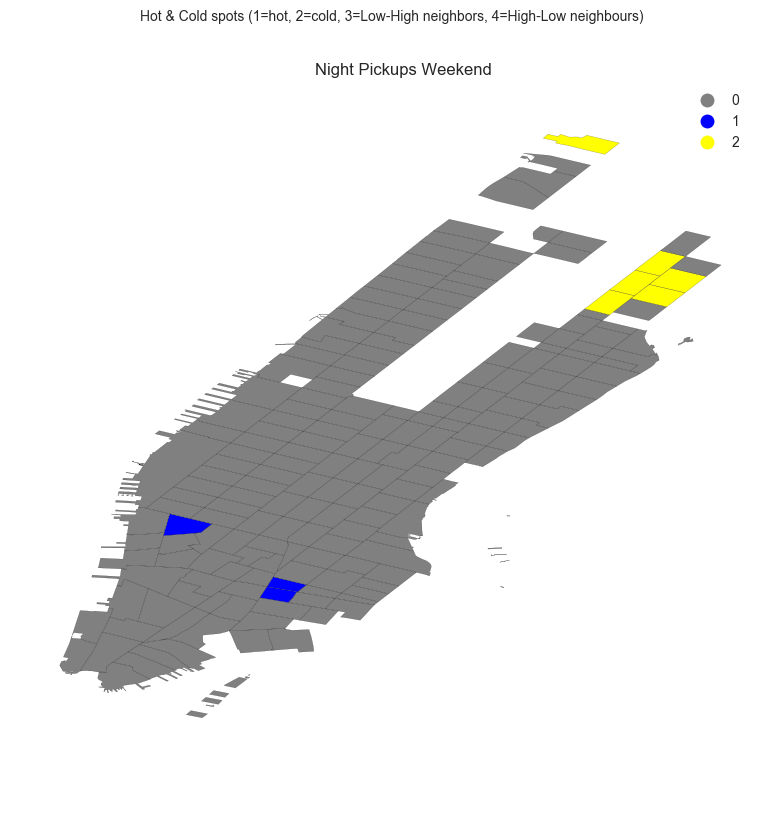

In [289]:
night_pickups_we = gp.read_file('./Temporal/night_pickups_we.shp')
hotspot_coldspot(night_pickups_we, 'id', 'Night Pickups Weekend')

('WARNING: ', 1024000, ' is an island (no neighbors)')
('WARNING: ', 1021200, ' is an island (no neighbors)')
Global Moran's I:  0.606204348255
p-value:  1e-05


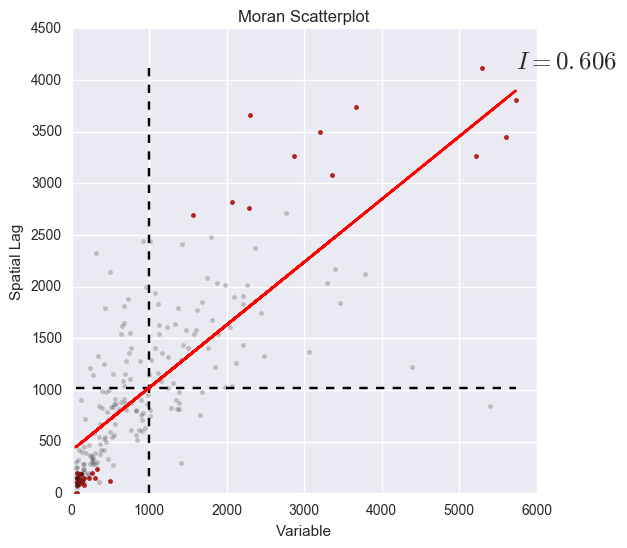

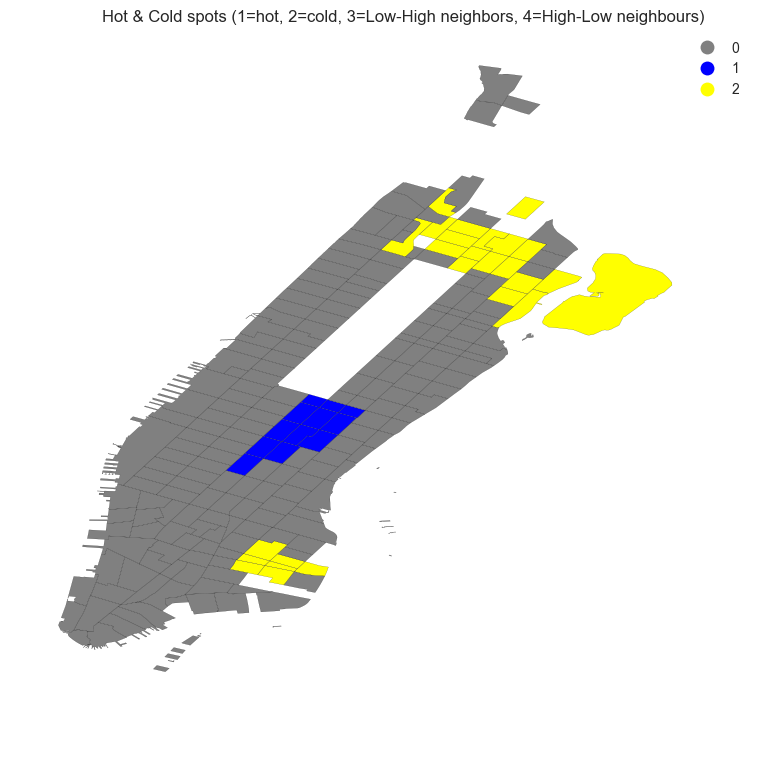

In [282]:
morning_dropoffs_wd = gp.read_file('./Temporal/morning_dropoffs_wd.shp')
hotspot_coldspot(morning_dropoffs_wd, 'id', 'Morning Dropoffs Weekday')

Global Moran's I:  0.645605694389
p-value:  1e-05


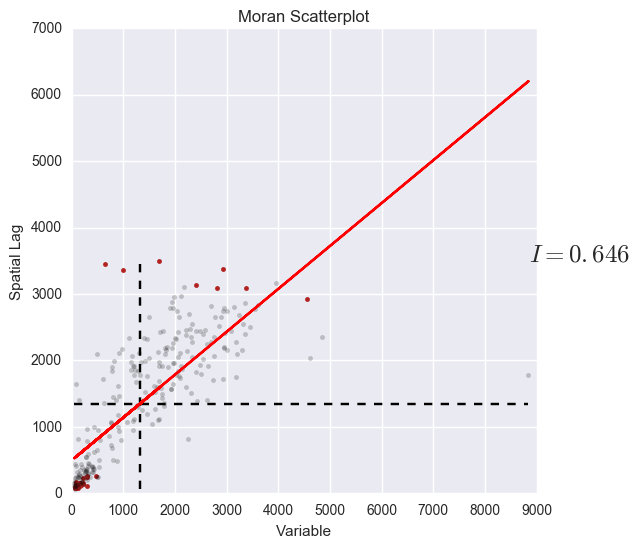

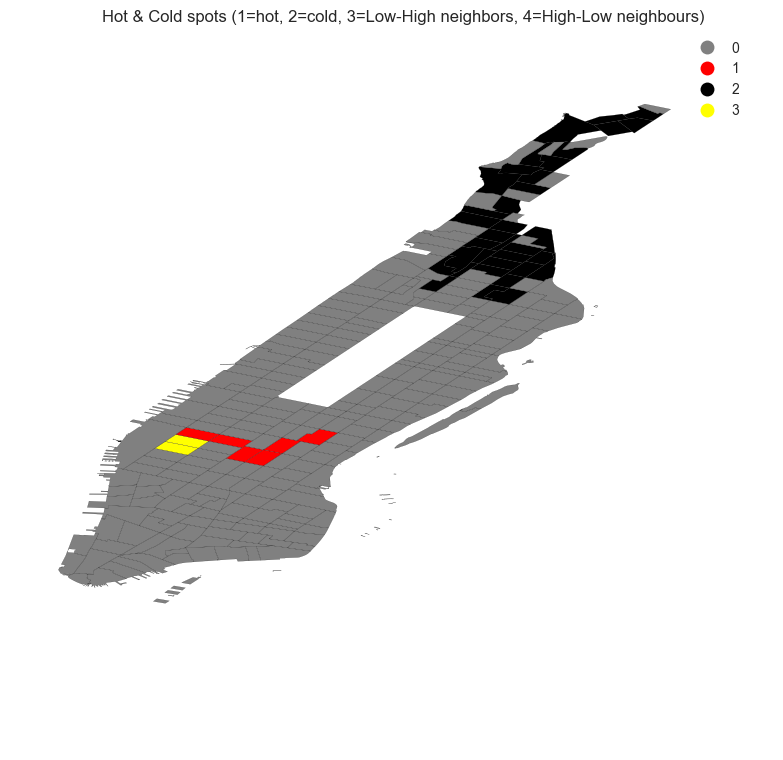

In [283]:
evening_dropoffs_wd = gp.read_file('./Temporal/evening_dropoffs_wd.shp')
hotspot_coldspot(evening_dropoffs_wd, 'id', 'Evening Dropoffs Weekday')

('WARNING: ', 1021200, ' is an island (no neighbors)')
('WARNING: ', 1024500, ' is an island (no neighbors)')
Global Moran's I:  0.384291566599
p-value:  1e-05


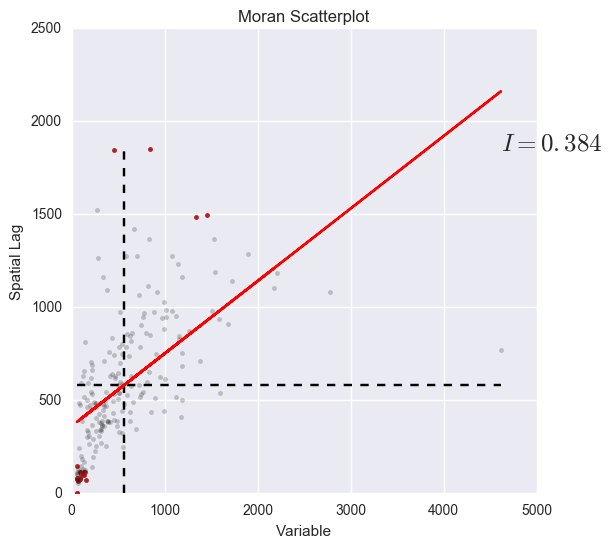

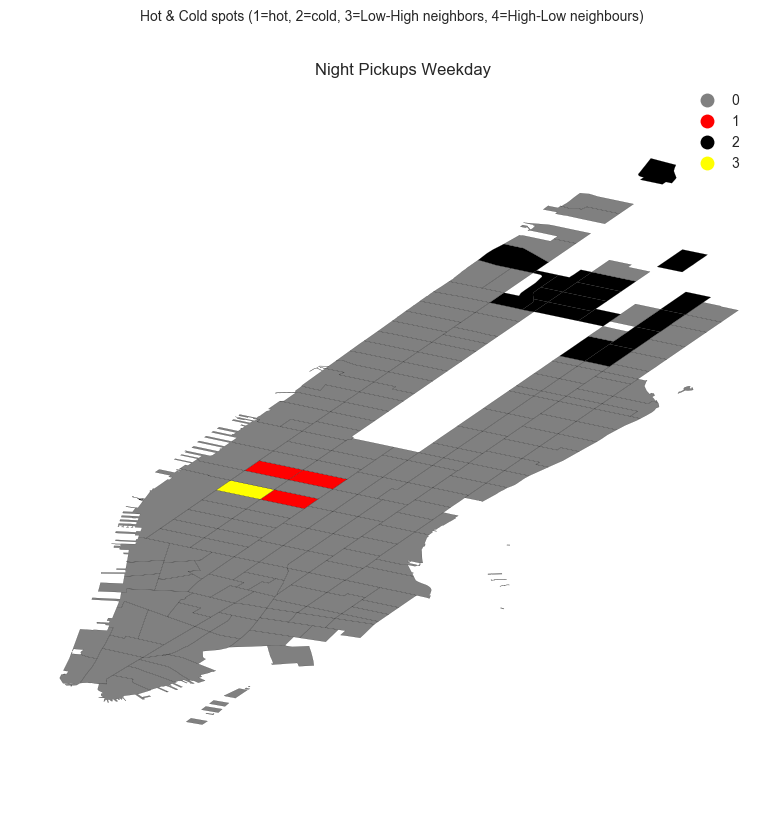

In [286]:
night_pickups_wd = gp.read_file('./Temporal/night_pickups_wd.shp')
hotspot_coldspot(night_pickups_wd, 'id', 'Night Pickups Weekday')

The hot and cold spots for all the temporal values give an idea about the census tracts which have statistically significant spatial similarity and attribute similarity.

For eg, the hot and cold spots for night pickups during weekends show two hotspots near Greenwich village and east village where most bars are located. Such places can be used to place advertsiments about food, car services, bars, etc during night. People who visit these places during night can be shown related advertisment

East harlem has really low values of taxi usage since these areas are served by Boro Taxi - http://www.nyc.gov/html/tlc/html/passenger/shl_passenger.shtml

The census tracts around penn station is a spatial outlier, it has a large number of pickups and dropoffs, it would be interesting to check the purchase data and customer type data visiting this census tract

Global Moran's I:  0.506832683312
p-value:  1e-05


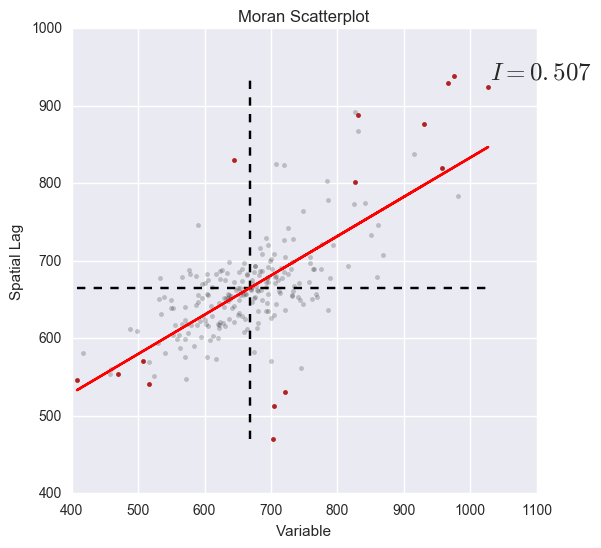

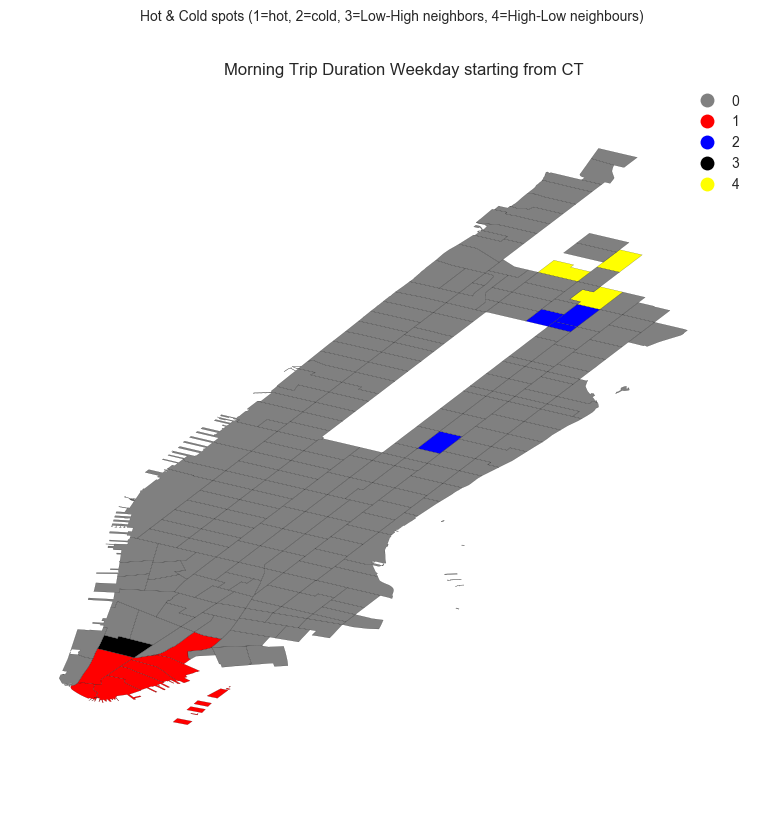

In [297]:
hotspot_coldspot(morning_pickups_wd, 'trip_durat', 'Morning Trip Duration Weekday starting from CT')

('WARNING: ', 1022900, ' is an island (no neighbors)')
Global Moran's I:  0.697591559235
p-value:  1e-05


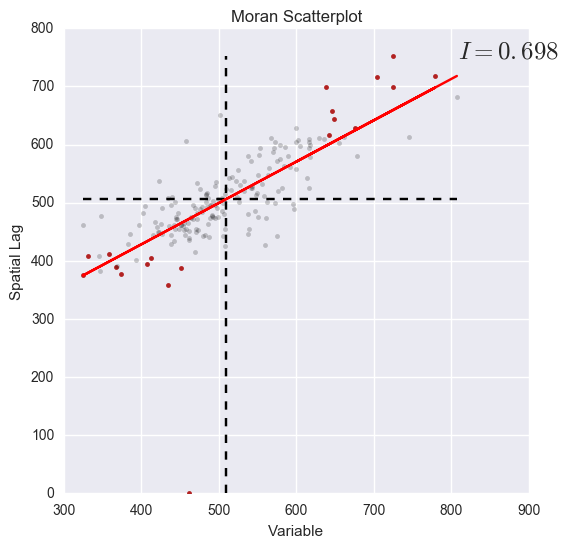

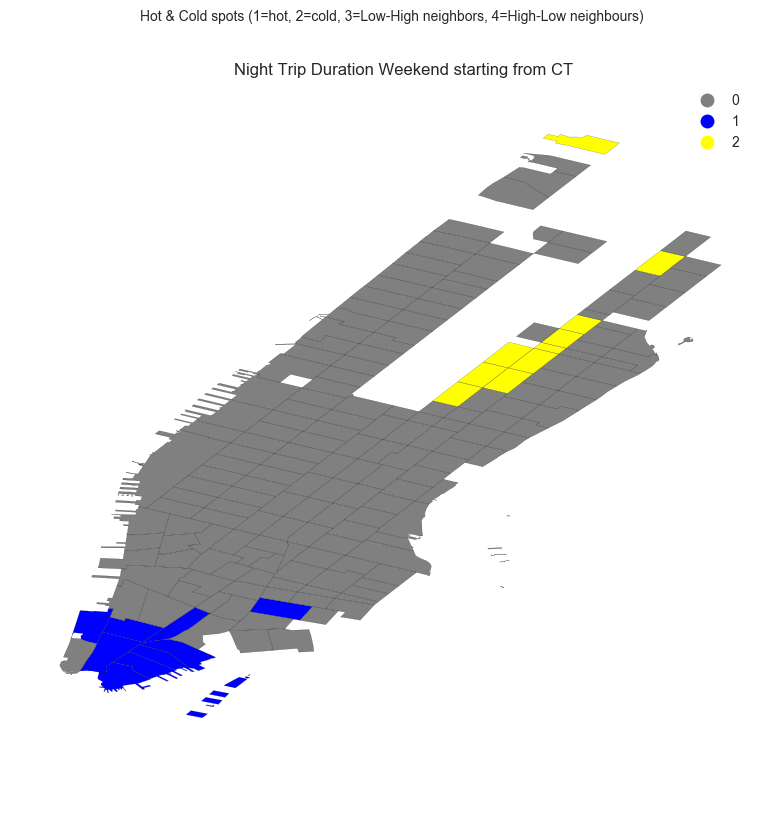

In [298]:
hotspot_coldspot(night_pickups_we, 'trip_durat', 'Night Trip Duration Weekend starting from CT')

('WARNING: ', 1021200, ' is an island (no neighbors)')
('WARNING: ', 1024500, ' is an island (no neighbors)')
Global Moran's I:  0.657153063267
p-value:  1e-05


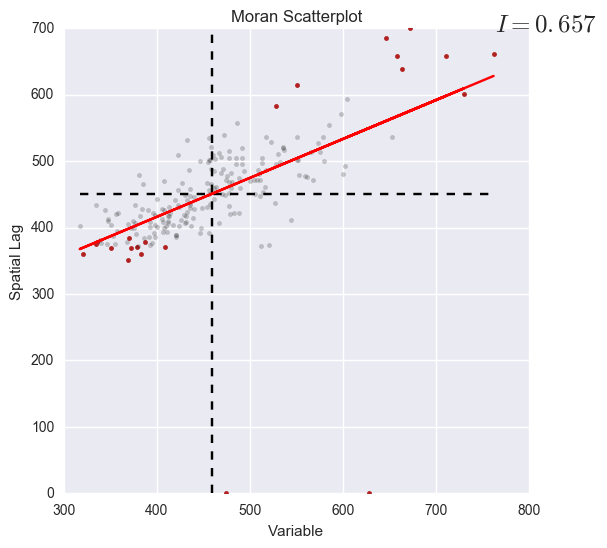

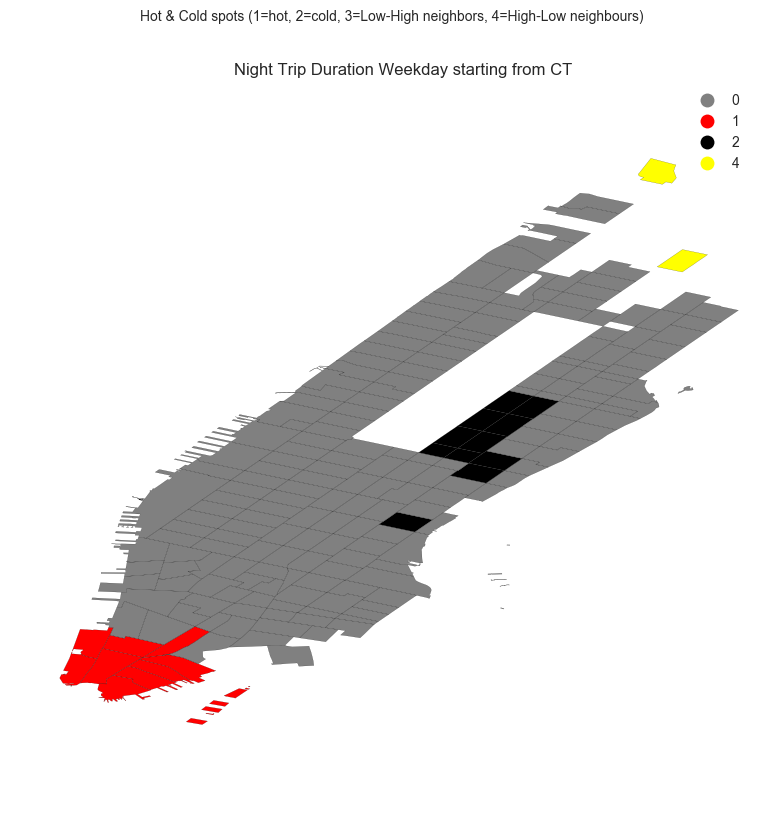

In [299]:
hotspot_coldspot(night_pickups_wd, 'trip_durat', 'Night Trip Duration Weekday starting from CT')

('WARNING: ', 1024000, ' is an island (no neighbors)')
('WARNING: ', 1021200, ' is an island (no neighbors)')
Global Moran's I:  0.76768583892
p-value:  1e-05


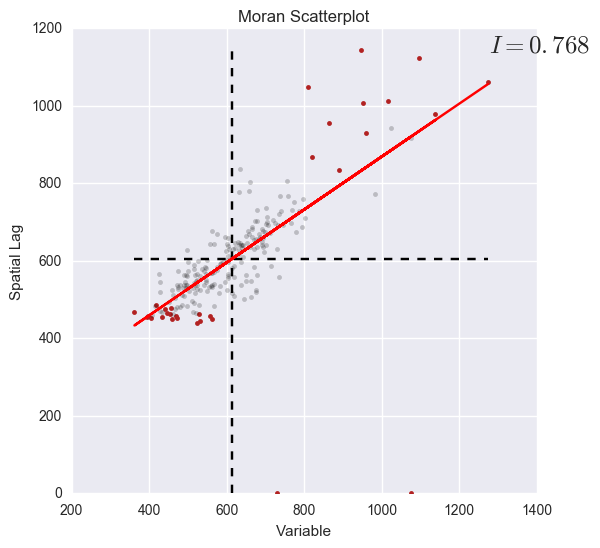

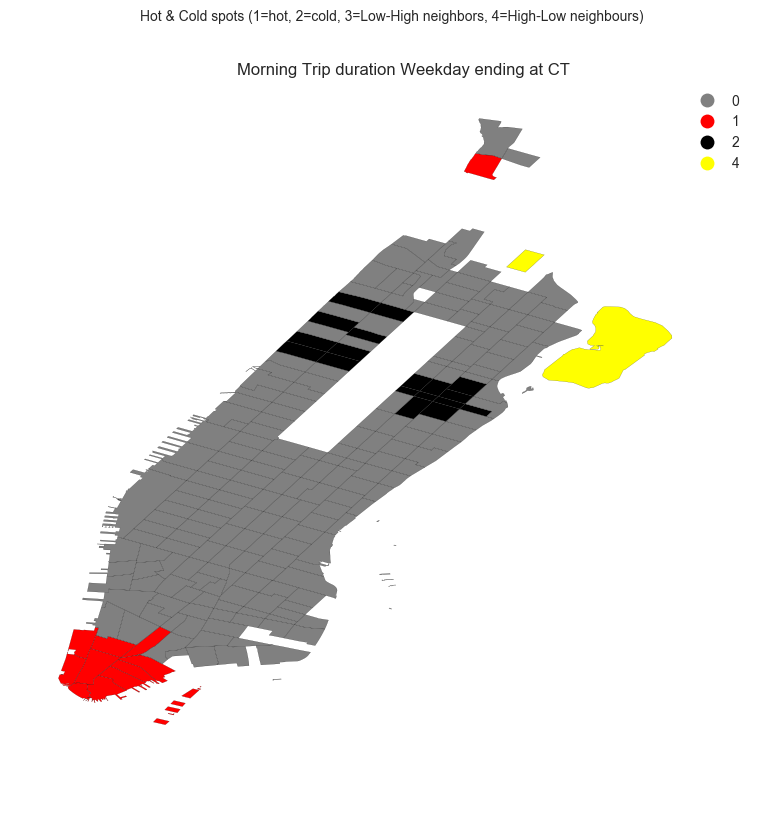

In [300]:
hotspot_coldspot(morning_dropoffs_wd, 'trip_durat', 'Morning Trip duration Weekday ending at CT')

Global Moran's I:  0.902325007671
p-value:  1e-05


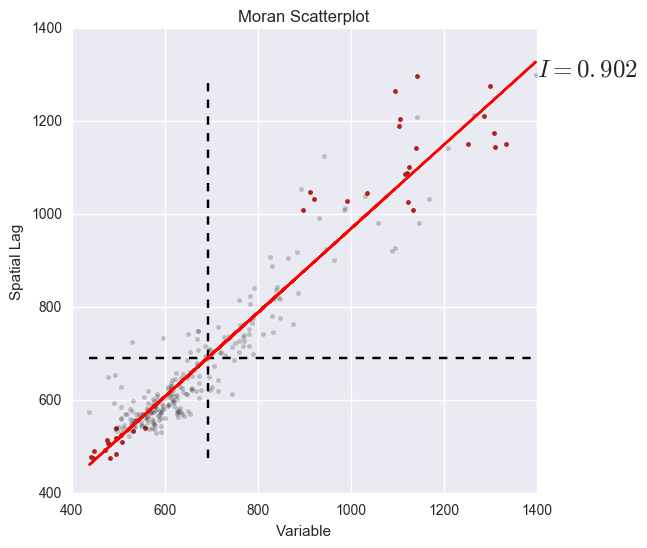

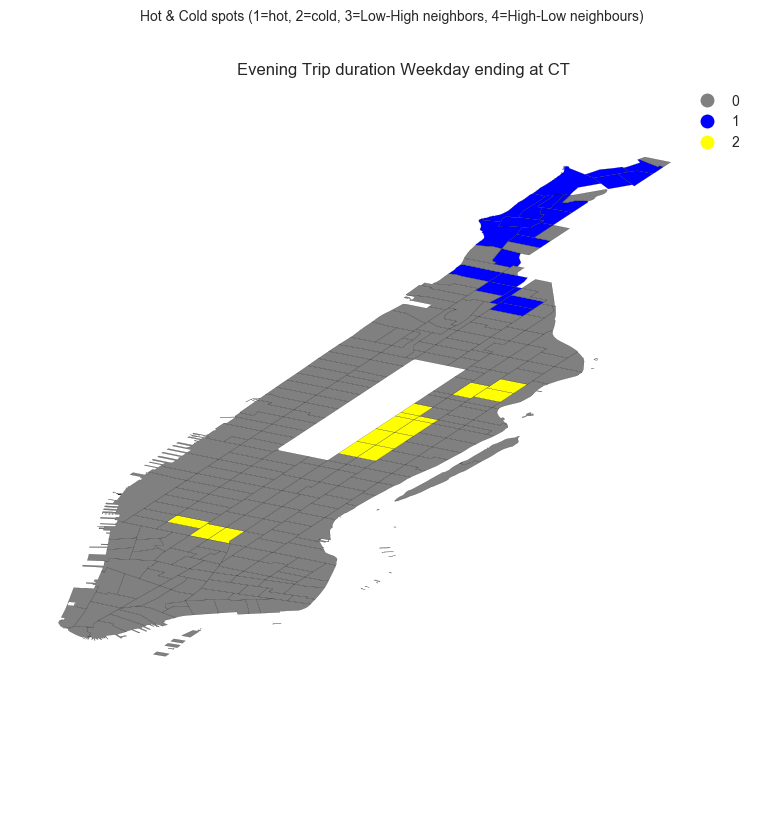

In [301]:
hotspot_coldspot(evening_dropoffs_wd, 'trip_durat', 'Evening Trip duration Weekday ending at CT')

The above plots show that there are some areas in Manhattan that have statistically significant trip duration values. This information can be used by potential companies strategise their products by focusing on these locations

The below plot gives a small idea about the population density in Manhattan. The information is taken from ACS. The areas with high population density are residential and the ones with lower values are either business or scenic 

A statistical way to prove this is to sample the population density in residential areas vs recreational areas. Compare them to check if they are statistically different and then compare the areas with the output of hotspots and coldspots

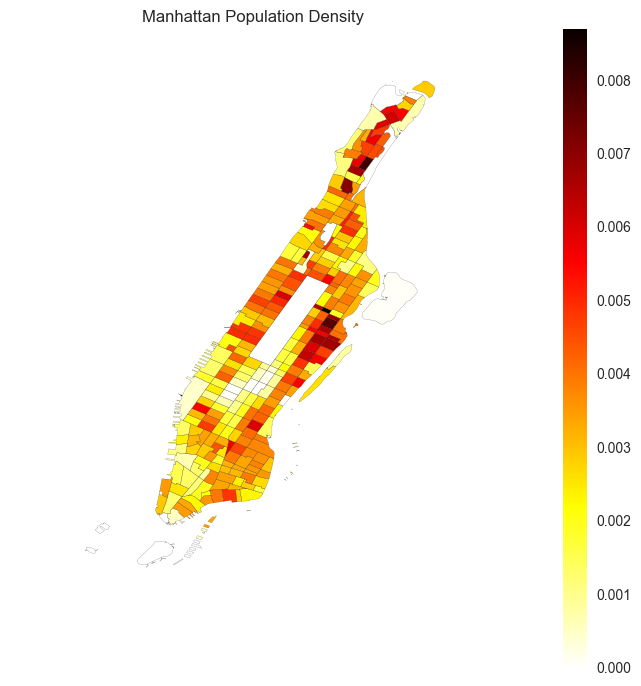

In [303]:
census = pd.read_csv("./nyc_census_tracts.csv")
census = census[census.Borough == 'Manhattan']
census.reset_index(inplace=True, drop=True)

nyct = gp.read_file('./nyct2010_17c/nyct2010.shp')
nyct.to_crs(epsg=4326, inplace=True)
nyct = nyct[nyct.BoroName == 'Manhattan']
nyct = nyct[['BoroCT2010', 'geometry', 'Shape_Area']]
nyct.BoroCT2010 = nyct.BoroCT2010.astype('int64')

census = pd.merge(census, nyct, left_on='CensusTract', right_on='BoroCT2010', how='left')

census['pop_den']  = census.TotalPop/census['Shape_Area']

crs = {'init': 'epsg:4326', 'no_defs': True}
census = gp.GeoDataFrame(census, crs=crs, geometry=census.geometry)

vmin, vmax = census.pop_den.min(), census.pop_den.max()

ax = census.plot(column='pop_den', colormap='hot_r', vmin=vmin, vmax=vmax, linewidth = 0.1, alpha = 1, figsize=(8,8))
ax.set_axis_off()
ax.set_title('Manhattan Population Density')
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='hot_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.show()

If we assume the population density metric as correct. We see that the upper east and west side are residential areas while midtown is not. The pickups during morning on weekdays is high in upper east & west side